
## Downloading the data 

### Elevation

TODO adapt from swan coastal

```bash
mkdir -p $HOME/data/Lithology/swan_coastal
cd $HOME/data/Lithology/swan_coastal
curl -o Swan_DEM.7z https://cloudstor.aarnet.edu.au/plus/s/HL3h7u67xUA1ilR/download
7za x Swan_DEM.7z
```

Windows:

```bat
mkdir -p c:\data\Lithology\swan_coastal
cd c:\data\Lithology\swan_coastal
curl -o Swan_DEM.7z https://cloudstor.aarnet.edu.au/plus/s/HL3h7u67xUA1ilR/download
7z x Swan_DEM.7z
```

### Borehole logs

TODO adapt from swan coastal

```bash
mkdir -p $HOME/data/Lithology/
cd $HOME/data/Lithology/
curl -o NGIS_SCP.7z https://cloudstor.aarnet.edu.au/plus/s/KLEBWonjOAOPVVd/download
7za x NGIS_SCP.7z
```

Windows:

```bat
cd c:\data\Lithology
curl -o NGIS_SCP.7z https://cloudstor.aarnet.edu.au/plus/s/KLEBWonjOAOPVVd/download
7z x NGIS_SCP.7z
```



In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd


In [2]:
# Only set to True for co-dev of ela from this use case:
ela_from_source = False
ela_from_source = True

In [3]:
if ela_from_source:
    if ('ELA_SRC' in os.environ):
        root_src_dir = os.environ['ELA_SRC']
    elif sys.platform == 'win32':
        root_src_dir = r'C:\src\github_jm\pyela'
    else:
        username = os.environ['USER']
        root_src_dir = os.path.join('/home', username, 'src/ela/pyela')
    pkg_src_dir = root_src_dir
    sys.path.insert(0, pkg_src_dir)

from ela.textproc import *
from ela.utils import *
from ela.classification import *
from ela.visual import *
from ela.spatial import SliceOperation

## Importing data

There are two main sets of information we need: the borehole lithology logs, and the spatial information in the surface elevation (DEM) and geolocation of a subset of bores around Bungendore. 

In [4]:
data_path = None

You probably want to explicitly set `data_path` to the location where you put the folder(s) e.g:

In [5]:
#data_path = '/home/myusername/data' # On Linux, if you now have the folder /home/myusername/data/Bungendore
#data_path = r'C:\data\Lithology'  # windows, if you have C:\data\Lithology\Bungendore

Otherwise a fallback for the pyela developer(s)

In [6]:
if data_path is None:
    if ('ELA_DATA' in os.environ):
        data_path = os.environ['ELA_DATA']
    elif sys.platform == 'win32':
        data_path = r'C:\data\Lithology'
    else:
        username = os.environ['USER']
        data_path = os.path.join('/home', username, 'data')

In [7]:
data_path

'/home/per202/data/Lithology'

In [8]:
#aem_datadir = os.path.join(data_path, 'AEM')
cbr_datadir = os.path.join(data_path, 'Canberra')
cbr_datadir_out = os.path.join(cbr_datadir, 'out')
# scp_datadir = os.path.join(aem_datadir, 'Swan_coastal_plains')
# scp_grids_datadir = os.path.join(scp_datadir, 'grids')
ngis_datadir = os.path.join(data_path, 'NGIS')
act_shp_datadir = os.path.join(ngis_datadir, 'shp_ACT')
bidgee_shp_datadir = os.path.join(ngis_datadir, 'shp_murrumbidgee_river')

## DEM


In [9]:
dem = rasterio.open(os.path.join(cbr_datadir,'CLIP.tif'))

In [10]:
dem.crs

CRS.from_dict(init='epsg:28355')

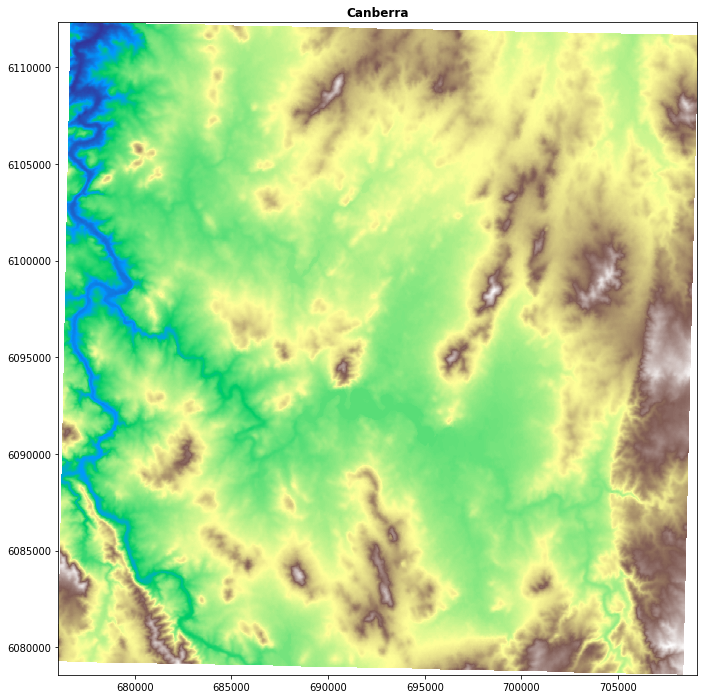

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
show(dem,title='Canberra', cmap='terrain',  ax=ax)

## Bore data

In [12]:
bore_locations_raw = gpd.read_file(os.path.join(cbr_datadir, 'Bores/act_bores.shp'))

In [13]:
bore_locations_raw.columns

Index(['HydroID', 'HydroCode', 'StateBoreI', 'StatePipeI', 'StateTerri',
       'Agency', 'WCode', 'BoreDepth', 'DrilledDep', 'Status', 'DrilledDat',
       'HGUID', 'HGUNumber', 'HGUName', 'NafHGUNumb', 'AquiferTyp', 'FType',
       'Latitude', 'Longitude', 'Easting', 'Northing', 'Projection',
       'Projecti_1', 'CoordMetho', 'HeightDatu', 'RefElev', 'RefElevDes',
       'RefElevMet', 'TsRefElev', 'TsRefElevD', 'TsRefElevM', 'LandElev',
       'LandElevMe', 'IsMultiPip', 'BoreLineCo', 'WorksID', 'LicenceExt',
       'LicenceE_1', 'LicenceUse', 'FTypeClass', 'Constructi', 'LithLog',
       'Hydrostrat', 'WaterLevel', 'Salinity', 'WaterCount', 'WaterDateM',
       'WaterDat_1', 'SalinityCo', 'SalinityDa', 'Salinity_1', 'geometry'],
      dtype='object')

In [14]:
bore_locations_raw.crs, dem.crs

({'init': 'epsg:3577'}, CRS.from_dict(init='epsg:28355'))

The DEM raster and the bore location shapefile do not use the same projection (coordinate reference system) so we reproject one of them. We choose the raster's UTM.

In [15]:
bore_locations = bore_locations_raw.to_crs(dem.crs)

In [16]:
lithology_logs_act = pd.read_csv(os.path.join(act_shp_datadir, 'NGIS_LithologyLog.csv'))
lithology_logs_bidgee = pd.read_csv(os.path.join(bidgee_shp_datadir, 'NGIS_LithologyLog.csv'))

In [17]:
len(lithology_logs_act), len(lithology_logs_bidgee)

(1735, 58944)

In [18]:
lithology_logs = pd.concat([lithology_logs_act, lithology_logs_bidgee])

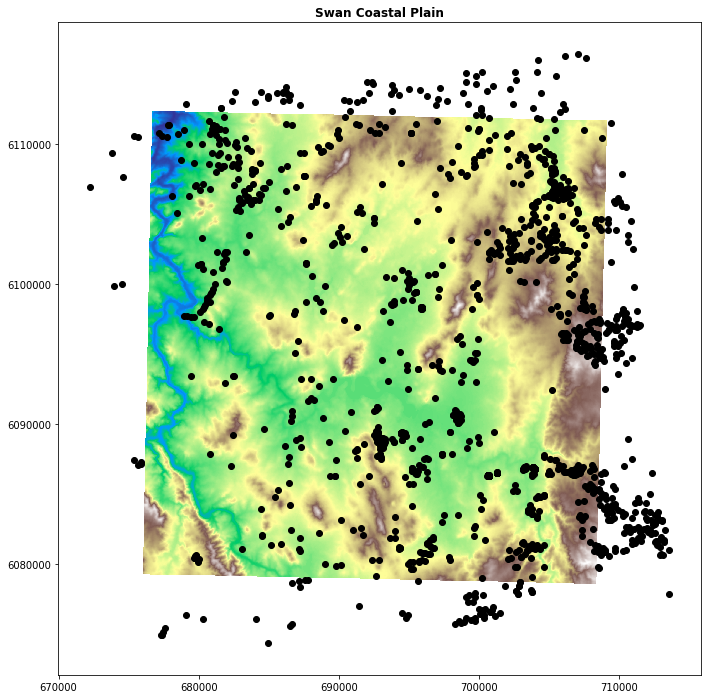

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
show(dem,title='Swan Coastal Plain', cmap='terrain',  ax=ax)
bore_locations.plot(ax=ax, facecolor='black')

### Subset to the location of interest

The lithology logs are for all of western australia, which is much larger than the area of interest and for which we have the geolocation of boreholes. We subset to the location of interest 

In [20]:
df = lithology_logs.copy()

Let's subset the logs based on spatial locations, to keep only those "nearby" the DEM we have near the locality of Bungendore in this case study. First define a few constants: 

In [21]:
df.columns

Index(['OBJECTID', 'BoreID', 'HydroCode', 'RefElev', 'RefElevDesc',
       'FromDepth', 'ToDepth', 'TopElev', 'BottomElev', 'MajorLithCode',
       'MinorLithCode', 'Description', 'Source', 'LogType'],
      dtype='object')

In [22]:
DEPTH_FROM_COL = 'FromDepth'
DEPTH_TO_COL = 'ToDepth'

TOP_ELEV_COL = 'TopElev'
BOTTOM_ELEV_COL = 'BottomElev'

LITHO_DESC_COL = 'Description'
HYDRO_CODE_COL = 'HydroCode'

### Merging the geolocation from the shapefile and lithology records

The geopandas data frame has a column geometry listing `POINT` objects. 'ela' includes  `get_coords_from_gpd_shape` to extrace the coordinates to a simpler structure. 'ela' has predefined column names (e.g. EASTING_COL) defined for easting/northing information, that we can use to name our coordinate information.

In [23]:
bore_locations.columns

Index(['HydroID', 'HydroCode', 'StateBoreI', 'StatePipeI', 'StateTerri',
       'Agency', 'WCode', 'BoreDepth', 'DrilledDep', 'Status', 'DrilledDat',
       'HGUID', 'HGUNumber', 'HGUName', 'NafHGUNumb', 'AquiferTyp', 'FType',
       'Latitude', 'Longitude', 'Easting', 'Northing', 'Projection',
       'Projecti_1', 'CoordMetho', 'HeightDatu', 'RefElev', 'RefElevDes',
       'RefElevMet', 'TsRefElev', 'TsRefElevD', 'TsRefElevM', 'LandElev',
       'LandElevMe', 'IsMultiPip', 'BoreLineCo', 'WorksID', 'LicenceExt',
       'LicenceE_1', 'LicenceUse', 'FTypeClass', 'Constructi', 'LithLog',
       'Hydrostrat', 'WaterLevel', 'Salinity', 'WaterCount', 'WaterDateM',
       'WaterDat_1', 'SalinityCo', 'SalinityDa', 'Salinity_1', 'geometry'],
      dtype='object')

In [24]:
geoloc = get_coords_from_gpd_shape(bore_locations, colname='geometry', out_colnames=[EASTING_COL, NORTHING_COL])
geoloc[HYDRO_CODE_COL] = bore_locations[HYDRO_CODE_COL]
# We keep lat/long for potential leaflet viewer
geoloc['Latitude'] = bore_locations['Latitude']
geoloc['Longitude'] = bore_locations['Longitude']
geoloc.head()

,Easting,Northing,HydroCode,Latitude,Longitude
0,705962.586117,6.087010e+06,GW402362.1.1,-35.338957,149.266272
1,683863.061659,6.106025e+06,GW403407.1.1,-35.171919,149.018992
2,706441.997736,6.101208e+06,GW414389.1.1,-35.210935,149.267973
3,705360.993305,6.102453e+06,GW414646.1.1,-35.199940,149.255795
4,706112.593736,6.102409e+06,GW401368.1.1,-35.200182,149.264056


In [25]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,2037706,80000001,EA-JC1,560,NGS,0,3.5,560,556.5,None,None,Poorly sorted sands and minor gravel in dark g...,Publication,2
1,2037707,80000001,EA-JC1,560,NGS,3.5,34,556.5,526,None,None,Dacite to rhyro-dacite. Minor fracturing no wa...,Publication,2
2,2037708,80000001,EA-JC1,560,NGS,34,36,526,524,None,None,Dacite to rhyro-dacite. Carbonaceous zones wit...,Publication,2
3,2037709,80000001,EA-JC1,560,NGS,48,60,512,500,None,None,Dacite to rhyro-dacite. Minor carbonaceous. Ma...,Publication,2
4,2037710,80000002,EA-JC2,559.63,NGS,0,2.5,559.63,557.13,None,None,Large pebbles with poorly sorted sands. Major ...,Publication,2


With this data frame we can perform two operations in one go: subsetting the lithology records to only the 640 bores of interest, and adding to the result the x/y geolocations to the data frame.

In [26]:
len(geoloc), len(df)

(1381, 60679)

In [27]:
geoloc[HYDRO_CODE_COL].dtype, df[HYDRO_CODE_COL].dtype

(dtype('O'), dtype('O'))

In [28]:
# geoloc[HYDRO_CODE_COL] = geoloc[HYDRO_CODE_COL].apply(parse_int)
# df[HYDRO_CODE_COL] = df[HYDRO_CODE_COL].apply(parse_int)

In [29]:
df = pd.merge(df, geoloc, how='inner', on=HYDRO_CODE_COL, sort=False, copy=True, indicator=False, validate=None)

In [30]:
len(df)

4658

In [31]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,Easting,Northing,Latitude,Longitude
0,2037706,80000001,EA-JC1,560,NGS,0,3.5,560,556.5,None,None,Poorly sorted sands and minor gravel in dark g...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161
1,2037707,80000001,EA-JC1,560,NGS,3.5,34,556.5,526,None,None,Dacite to rhyro-dacite. Minor fracturing no wa...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161
2,2037708,80000001,EA-JC1,560,NGS,34,36,526,524,None,None,Dacite to rhyro-dacite. Carbonaceous zones wit...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161
3,2037709,80000001,EA-JC1,560,NGS,48,60,512,500,None,None,Dacite to rhyro-dacite. Minor carbonaceous. Ma...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161
4,2037710,80000002,EA-JC2,559.63,NGS,0,2.5,559.63,557.13,None,None,Large pebbles with poorly sorted sands. Major ...,Publication,2,696387.999999,6.087492e+06,-35.336543,149.160873


### Round up 'depth to' and 'depth from' columns

We round the depth related columns to the upper integer value and drop the entries where the resulting depths have degenerated to 0. `ela` has a class `DepthsRounding` to facilitate this operations on lithology records with varying column names.

We first clean up height/depths columns to make sure they are numeric.

In [32]:
def as_numeric(x):
    if isinstance(x, float):
        return x
    if x == 'None':
        return np.nan
    elif x is None:
        return np.nan
    elif isinstance(x, str):
        return float(x)
    else:
        return float(x)

In [33]:
df[DEPTH_FROM_COL] = df[DEPTH_FROM_COL].apply(as_numeric)
df[DEPTH_TO_COL] = df[DEPTH_TO_COL].apply(as_numeric)
df[TOP_ELEV_COL] = df[TOP_ELEV_COL].apply(as_numeric)
df[BOTTOM_ELEV_COL] = df[BOTTOM_ELEV_COL].apply(as_numeric)

In [34]:
dr = DepthsRounding(DEPTH_FROM_COL, DEPTH_TO_COL)

In [35]:
"Before rounding heights we have " + str(len(df)) + " records"

'Before rounding heights we have 4658 records'

In [36]:
df = dr.round_to_metre_depths(df, np.round, True)
"After removing thin sliced entries of less than a metre, we are left with " + str(len(df)) + " records left"

'After removing thin sliced entries of less than a metre, we are left with 3946 records left'

## Exploring the descriptive lithology 

In [37]:
descs = df[LITHO_DESC_COL]
descs = descs.reset_index()
descs = descs[LITHO_DESC_COL]
descs.head()

0    Poorly sorted sands and minor gravel in dark g...
1    Dacite to rhyro-dacite. Minor fracturing no wa...
2    Dacite to rhyro-dacite. Carbonaceous zones wit...
3    Dacite to rhyro-dacite. Minor carbonaceous. Ma...
4    Large pebbles with poorly sorted sands. Major ...
Name: Description, dtype: object

The description column as read seems to be objects. Other columns seem to be objects when they should be numeric. We define two functions to clean these.

In [38]:
def clean_desc(x):
    if isinstance(x, float):
        return u''
    elif x is None:
        return u''
    else:
        # python2 return unicode(x)        
        return x

In [39]:
y = [clean_desc(x) for x in descs]

In [40]:
from striplog import Lexicon
lex = Lexicon.default()

In [41]:
y = clean_lithology_descriptions(y, lex)

We get a flat list of all the "tokens" but remove stop words ('s', 'the' and the like)

In [42]:
y = v_lower(y)
vt = v_word_tokenize(y)
flat = np.concatenate(vt)

In [43]:
import nltk
from nltk.corpus import stopwords

In [44]:
stoplist = stopwords.words('english')
exclude = stoplist + ['.',',',';',':','(',')','-']
flat = [word for word in flat if word not in exclude]

In [45]:
len(set(flat))

739

In [46]:
df_most_common= token_freq(flat, 50)

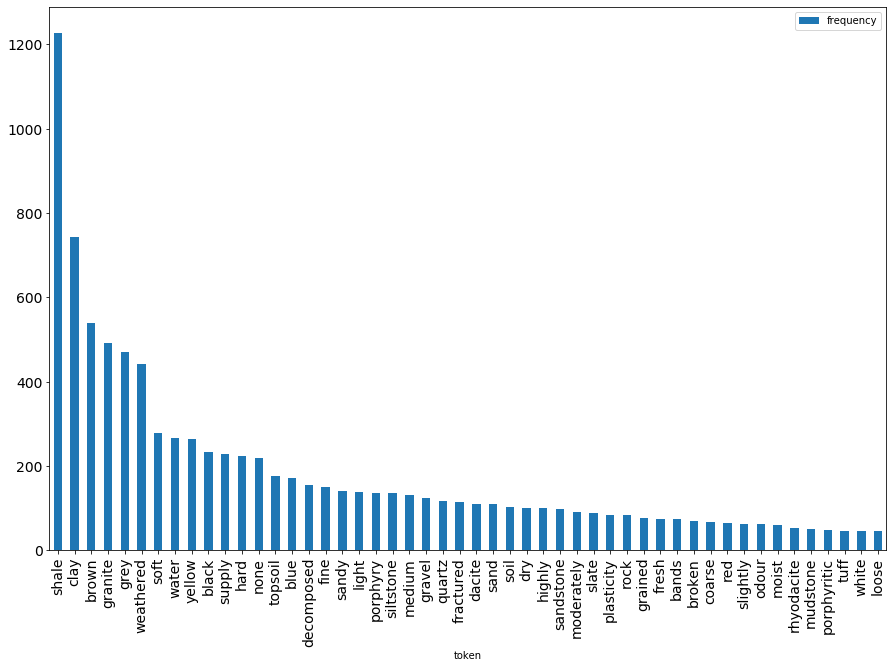

In [47]:
plot_freq(df_most_common)

In [48]:
df_most_common

,token,frequency
0,shale,1228
1,clay,743
2,brown,539
3,granite,491
4,grey,470
5,weathered,441
6,soft,278
7,water,267
8,yellow,265
9,black,232


## Defining lithology classes and finding primary/secondary lithologies

From the list of most common tokens, we may want to define lithology classes as follows:

In [49]:
df[LITHO_DESC_COL] = y

In [50]:
lithologies = ['shale', 'clay','granite','soil','sand', 'porphyry','siltstone','gravel']

In [51]:
# Prep for visualisation
lithology_color_names = ['lightslategrey', 'olive', 'dimgray', 'chocolate',  'gold',     'tomato', 'teal', 'lavender']


And to capture any of these we devise a regular expression:

In [52]:
my_lithologies_numclasses = create_numeric_classes(lithologies)

In [53]:
lithologies_dict = dict([(x,x) for x in lithologies])
lithologies_dict['dacite'] = 'granite'
lithologies_dict['sandstone'] = 'granite'
lithologies_dict['slate'] = 'granite'
lithologies_dict['rock'] = 'granite'
lithologies_dict['ryodacite'] = 'granite'
lithologies_dict['mudstone'] = 'sand' # ??
lithologies_dict['topsoil'] = 'soil' # ??

In [54]:
any_litho_markers_re = r'shale|clay|granit|soil|sand|porphy|silt|gravel|dacit|slat|rock|stone'
regex = re.compile(any_litho_markers_re)

In [55]:
lithologies_adjective_dict = {
    'sandy' :  'sand',
    'clayey' :  'clay',
    'clayish' :  'clay',
    'shaley' :  'shale',
    'silty' :  'silt',
    'pebbly' :  'pebble',
    'gravelly' :  'gravel',
    'porphyritic': 'porphyry'
}

In [56]:
v_tokens = v_word_tokenize(y)
litho_terms_detected = v_find_litho_markers(v_tokens, regex=regex)

Let's see if we detect these lithology markers in each bore log entries  

In [57]:
zero_mark = [x for x in litho_terms_detected if len(x) == 0 ]
at_least_one_mark = [x for x in litho_terms_detected if len(x) >= 1]
at_least_two_mark = [x for x in litho_terms_detected if len(x) >= 2]
print('There are %s entries with no marker, %s entries with at least one, %s with at least two'%(len(zero_mark),len(at_least_one_mark),len(at_least_two_mark)))

There are 526 entries with no marker, 3420 entries with at least one, 763 with at least two


Note: probably need to think of precanned facilities in ela to assess the detection rate in such EDA. Maybe wordcloud not such a bad idea too.

In [58]:
descs_zero_mark = [y[i] for i in range(len(litho_terms_detected)) if len(litho_terms_detected[i]) == 0 ]

In [59]:
import random
random.sample(descs_zero_mark,20)
# descs_zero_mark[1:20]

['some broken band',
 'none',
 'purple and pale bluish grey moderately to highly weathered ignimbrite, hard and soft bands',
 'moderately weathered brown/grey ignimbrite. quartz phenocrysts upper to 2mm.',
 'none',
 'sediment - fractured quartz - light brown',
 'volcanics, yellow brown, intensely weathered/fractured',
 'highly weathered medium grained tuff - fresh limonite stained quartz, weathered feldspar and biotite micaeous phenos.  pitted - removal of pyrite',
 'calcite',
 'basalt',
 'not cored',
 'none',
 'moderately weathered to highly weathered rhyolite',
 'basalt',
 'none',
 'none',
 'none',
 'none',
 'light brown',
 'none']

In [60]:
primary_litho = v_find_primary_lithology(litho_terms_detected, lithologies_dict)

In [61]:
secondary_litho = v_find_secondary_lithology(litho_terms_detected, primary_litho, lithologies_adjective_dict, lithologies_dict)

In [62]:
df[PRIMARY_LITHO_COL]=primary_litho
df[SECONDARY_LITHO_COL]=secondary_litho

In [63]:
df[PRIMARY_LITHO_NUM_COL] = v_to_litho_class_num(primary_litho, my_lithologies_numclasses)
df[SECONDARY_LITHO_NUM_COL] = v_to_litho_class_num(secondary_litho, my_lithologies_numclasses)

In [64]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,Source,LogType,Easting,Northing,Latitude,Longitude,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num
0,2037706,80000001,EA-JC1,560,NGS,0.0,4.0,560.00,556.50,None,...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161,gravel,clay,7.0,1.0
1,2037707,80000001,EA-JC1,560,NGS,4.0,34.0,556.50,526.00,None,...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN
2,2037708,80000001,EA-JC1,560,NGS,34.0,36.0,526.00,524.00,None,...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN
3,2037709,80000001,EA-JC1,560,NGS,48.0,60.0,512.00,500.00,None,...,Publication,2,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN
4,2037710,80000002,EA-JC2,559.63,NGS,0.0,2.0,559.63,557.13,None,...,Publication,2,696387.999999,6.087492e+06,-35.336543,149.160873,,,NaN,NaN


## Converting depth below ground to Australian Height Datum elevation

While the bore entries have columns for AHD elevations, many appear to be missing data. Since we have a DEM of the region we can correct this.

In [65]:
cd = HeightDatumConverter(dem)

In [66]:
df = cd.add_height(df, 
        depth_from_col=DEPTH_FROM_COL, depth_to_col=DEPTH_TO_COL, 
        depth_from_ahd_col=DEPTH_FROM_AHD_COL, depth_to_ahd_col=DEPTH_TO_AHD_COL, 
        easting_col=EASTING_COL, northing_col=NORTHING_COL, drop_na=False)

In [67]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,Easting,Northing,Latitude,Longitude,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num,Depth From (AHD),Depth To (AHD)
0,2037706,80000001,EA-JC1,560,NGS,0.0,4.0,560.00,556.50,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,gravel,clay,7.0,1.0,565.066223,561.066223
1,2037707,80000001,EA-JC1,560,NGS,4.0,34.0,556.50,526.00,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN,561.066223,531.066223
2,2037708,80000001,EA-JC1,560,NGS,34.0,36.0,526.00,524.00,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN,531.066223,529.066223
3,2037709,80000001,EA-JC1,560,NGS,48.0,60.0,512.00,500.00,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN,517.066223,505.066223
4,2037710,80000002,EA-JC2,559.63,NGS,0.0,2.0,559.63,557.13,None,...,696387.999999,6.087492e+06,-35.336543,149.160873,,,NaN,NaN,566.494324,564.494324


In [68]:
# to be reused in experimental notebooks:
classified_logs_filename = os.path.join(cbr_datadir_out,'classified_logs.pkl')
df.to_pickle(classified_logs_filename)


## Interpolate over a regular grid


In [69]:
# max/min bounds
shp_bbox = get_bbox(bore_locations)
shp_bbox

(672212.6178483185, 6074390.022793734, 713568.9999099242, 6116384.006065217)

In [70]:
raster_bbox = dem.bounds
raster_bbox

BoundingBox(left=676054.1501277187, bottom=6078583.707593412, right=709102.3942995651, top=6112313.979829742)

In [71]:
x_min = max(shp_bbox[0], raster_bbox[0])
x_max = min(shp_bbox[2], raster_bbox[2])
y_min = max(shp_bbox[1], raster_bbox[1])
y_max = min(shp_bbox[3], raster_bbox[3])


In [72]:
grid_res = 200
m = create_meshgrid_cartesian(x_min, x_max, y_min, y_max, grid_res)

In [73]:
[x.shape for x in m]

[(166, 169), (166, 169)]

In [74]:
dem_array = surface_array(dem, x_min, y_min, x_max, y_max, grid_res)

In [75]:
dem_array.shape

(166, 169)

In [76]:
dem_array[dem_array <= 0.0] = np.nan

/home/per202/anaconda3/envs/ELA/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


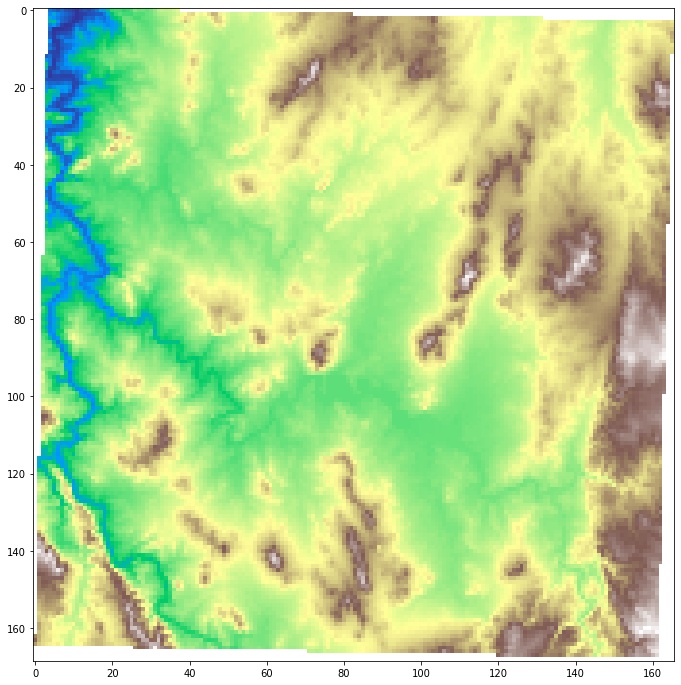

In [77]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(to_carto(dem_array), cmap='terrain')

In [78]:
dem_array_data = {'bounds': (x_min, x_max, y_min, y_max), 'grid_res': grid_res, 'mesh_xy': m, 'dem_array': dem_array}

In [79]:
import pickle

fp = os.path.join(cbr_datadir_out, 'dem_array_data.pkl')
if not os.path.exists(fp):
    with open(fp, 'wb') as handle:
        pickle.dump(dem_array_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

We need to define min and max heights on the Z axis for which we interoplate. We use the KNN algorithm with 10 neighbours. We should use a domain such that there are enough points for each height. Let's find visually heights with at least 10 records

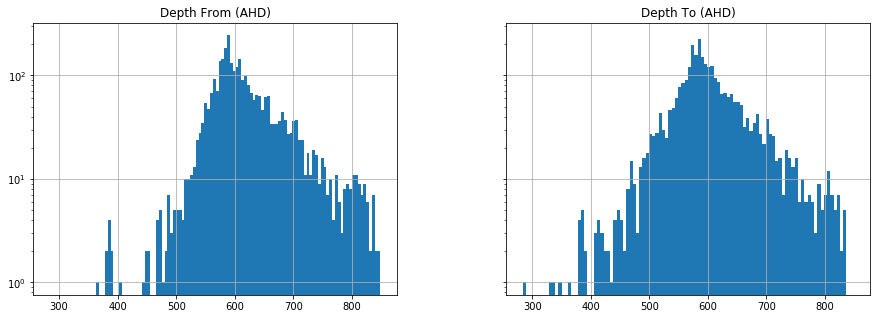

In [80]:
n_bins=100
p = df.hist(column=[DEPTH_FROM_AHD_COL,DEPTH_TO_AHD_COL], sharex=True, sharey=True, bins=n_bins, figsize=(15,5))
for axes in p:
    axes[0].set_yscale("log", nonposy='clip')

In [81]:
n_neighbours=10
ahd_min=530
ahd_max=710

z_ahd_coords = np.arange(ahd_min,ahd_max,1)
dim_x,dim_y = m[0].shape
dim_z = len(z_ahd_coords)
dims = (dim_x,dim_y,dim_z)

In [82]:
dims

(166, 169, 180)

In [83]:
lithology_3d_array=np.empty(dims)

In [84]:
gi = GridInterpolation(easting_col=EASTING_COL, northing_col=NORTHING_COL)

In [85]:
gi.interpolate_volume(lithology_3d_array, df, PRIMARY_LITHO_NUM_COL, z_ahd_coords, n_neighbours, m)

In [86]:
# Burn DEM into grid
z_index_for_ahd = z_index_for_ahd_functor(b=-ahd_min)

In [87]:
dem_array.shape, m[0].shape, lithology_3d_array.shape

((166, 169), (166, 169), (166, 169, 180))

In [88]:
burn_volume(lithology_3d_array, dem_array, z_index_for_ahd, below=False)

In [89]:
# to be reused in experimental notebooks:
interp_litho_filename = os.path.join(cbr_datadir_out,'3d_primary_litho.pkl')
with open(interp_litho_filename, 'wb') as handle:
    pickle.dump(lithology_3d_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 2D visualisations

In [90]:
lithology_cmap = discrete_classes_colormap(lithology_color_names) # Later for exporting to RGB geotiffs??
litho_legend_display_info = [(lithology_cmap[i], lithologies[i], lithology_color_names[i]) for i in range(len(lithologies))]

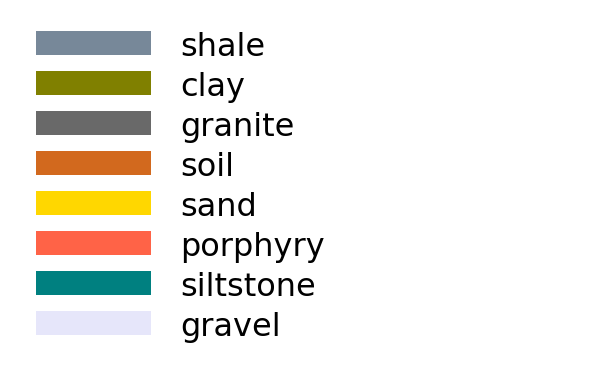

In [91]:
litho_legend = legend_fig(litho_legend_display_info)

In [92]:
cms = cartopy_color_settings(lithology_color_names)

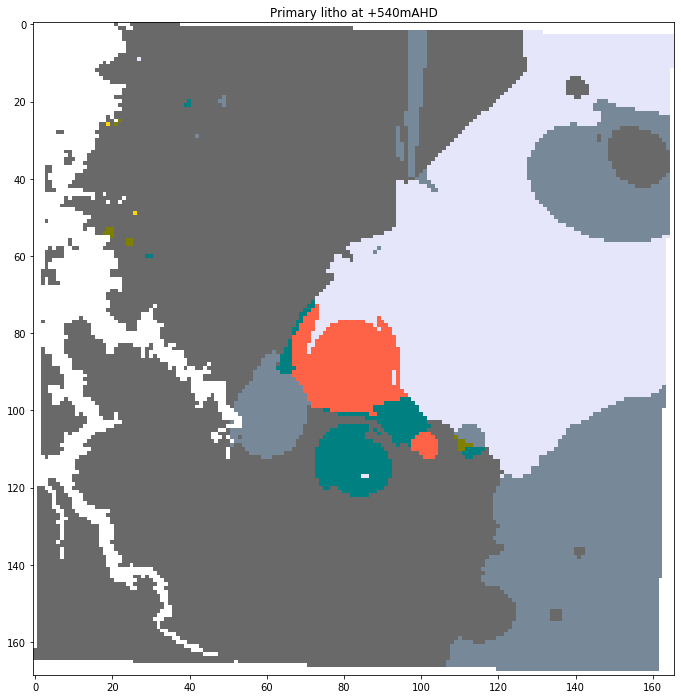

In [93]:
fig, ax = plt.subplots(figsize=(12, 12))
imgplot = plt.imshow(to_carto(lithology_3d_array[:, :, z_index_for_ahd(540)]), cmap=cms['cmap'])
title = plt.title('Primary litho at +540mAHD')

## 3D visualisation

In [94]:
from ela.visual3d import *

In [95]:
xx, yy = dem_array_data['mesh_xy']

In [96]:
from mayavi import mlab

In [97]:
vis_litho = LithologiesClassesVisual3d(lithologies, lithology_color_names, 'black')

In [131]:
# TODO: problematic with this data - investigate
# vis_litho.render_classes_planar(lithology_3d_array, 'Primary lithology')

In [132]:
# vis_litho.render_class(lithology_3d_array, 0)

ela has facilities to visualise overlaid information: DEM, classified bore logs, and volumes of interpolated lithologies. This is important to convey .

First a bit of data filling for visual purposes, as NaN lithology class codes may cause issues.

In [133]:
df_infilled = df.fillna({PRIMARY_LITHO_NUM_COL: -1.0})
df_infilled = df_infilled[(df_infilled[DEPTH_TO_AHD_COL] > (ahd_min-20))]

In [134]:
# A factor to apply to Z coordinates, otherwise things would be squashed visually along the heights.
# Would prefer a visual only scaling factor, but could not find a way to do so. 
Z_SCALING = 20.0

In [135]:
z_coords = np.arange(ahd_min,ahd_max,1)

In [136]:
overlay_vis_litho = LithologiesClassesOverlayVisual3d(lithologies, lithology_color_names, 'black', dem_array_data, z_coords, Z_SCALING, df_infilled, PRIMARY_LITHO_NUM_COL)

In [137]:
def view_class(value):
    f = overlay_vis_litho.view_overlay(value, lithology_3d_array)
    return f

In [145]:
f = view_class(7.0)

In [139]:
f = view_class(1.0)

In [140]:
f = view_class(2.0)

![3D Interpolated overlay primary lithology quartz](img/snapshot_quartz.png)

In [146]:
vis_litho = LithologiesClassesVisual3d(lithologies, lithology_color_names, 'black')

In [147]:
vis_litho.render_classes_planar(lithology_3d_array, 'Primary lithology')

### Export volumes for depth from ground

In [149]:
max_depth = 100
dim_x,dim_y = (lithology_3d_array.shape[0],lithology_3d_array.shape[1])
dim_z = max_depth + 1
dims = (dim_x,dim_y,dim_z)

In [153]:
grid_res = dem_array_data['grid_res']
x_min, x_max, y_min, y_max = dem_array_data['bounds']
xx, yy = dem_array_data['mesh_xy']
dem_array = dem_array_data['dem_array']

In [154]:
litho_classes_depth=np.empty(dims)
for depth in range(0, dim_z, 1):
    s = slice_volume(lithology_3d_array, dem_array - depth, z_index_for_ahd)
    litho_classes_depth[:,:,(max_depth - depth)] = s

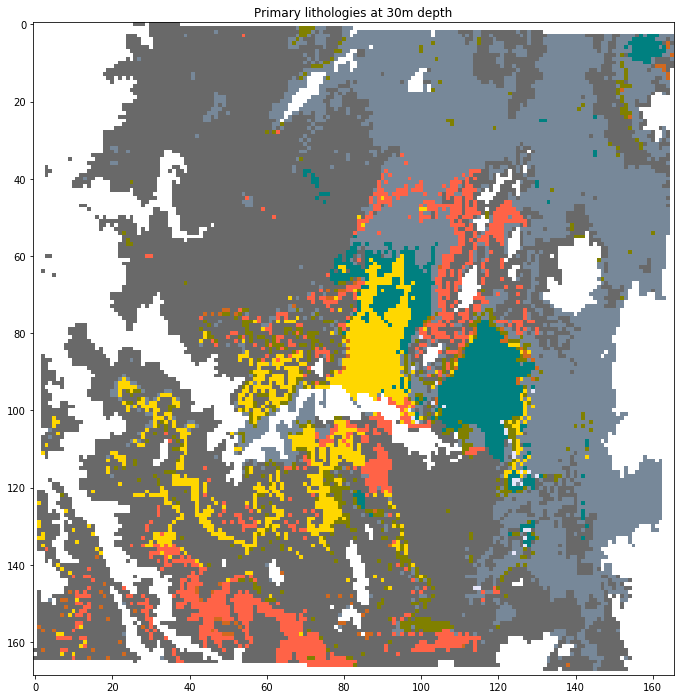

In [157]:
fig, ax = plt.subplots(figsize=(12, 12))
imgplot = plt.imshow(to_carto(litho_classes_depth[:,:,dim_z-30]), cmap=cms['cmap'])
t = plt.title('Primary lithologies at 30m depth')

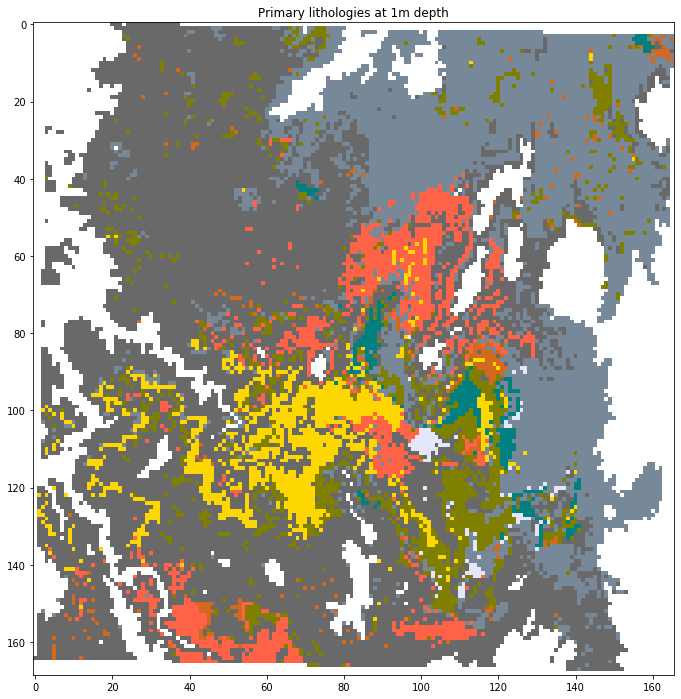

In [158]:
fig, ax = plt.subplots(figsize=(12, 12))
imgplot = plt.imshow(to_carto(litho_classes_depth[:,:,dim_z-1]), cmap=cms['cmap'])
t = plt.title('Primary lithologies at 1m depth')

# Viewer

Derived from [voila-gpx-viewer](https://github.com/jtpio/voila-gpx-viewer) and [ipyleaflet docs](https://ipyleaflet.readthedocs.io/en/latest/api_reference/popup.html)

However this is very difficult to adapt, actually use case is quite different from the GPX data. ipyleaflet doc is sparse and how to I guess the content of callbacks??
https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6




In [107]:
import datetime
import json

from io import StringIO
#from statistics import mean

from bqplot import Axis, Figure, Lines, LinearScale, LogScale
from bqplot.interacts import IndexSelector
from ipyleaflet import basemaps, FullScreenControl, LayerGroup, Map, MeasureControl, Polyline, Marker, CircleMarker, WidgetControl, MarkerCluster
from ipywidgets import Button, HTML, HBox, VBox, Checkbox, FileUpload, Label, Output, IntSlider, Layout, Image, link

In [100]:
# create the output widget to place the results
out = Output()

In [101]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,Easting,Northing,Latitude,Longitude,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num,Depth From (AHD),Depth To (AHD)
0,2037706,80000001,EA-JC1,560,NGS,0.0,4.0,560.00,556.50,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,gravel,clay,7.0,1.0,565.066223,561.066223
1,2037707,80000001,EA-JC1,560,NGS,4.0,34.0,556.50,526.00,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN,561.066223,531.066223
2,2037708,80000001,EA-JC1,560,NGS,34.0,36.0,526.00,524.00,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN,531.066223,529.066223
3,2037709,80000001,EA-JC1,560,NGS,48.0,60.0,512.00,500.00,None,...,696234.000000,6.087567e+06,-35.335898,149.159161,granite,,2.0,NaN,517.066223,505.066223
4,2037710,80000002,EA-JC2,559.63,NGS,0.0,2.0,559.63,557.13,None,...,696387.999999,6.087492e+06,-35.336543,149.160873,,,NaN,NaN,566.494324,564.494324


In [150]:
out = Output(layout={'border': '1px solid black'})

In [151]:
class GlobalThing:
    def __init__(self):
        self.marker_info = dict()
    
    def add_marker_info(self, lat, lon, code):
        self.marker_info[(lat, lon)] = code
    
    def get_code(self, lat, lon):
        return self.marker_info[(lat, lon)]
    
globalthing = GlobalThing()

In [152]:
def click_handler(**kwargs):
    blah = dict(**kwargs)
    xy = blah['coordinates']
    code = globalthing.get_code(xy[0], xy[1])
    bore_data = df.loc[df['HydroCode'] == code]
    out.clear_output()
    with out:
        print(code)        
        print(bore_data)

In [153]:
def plot_map(geoloc):
    """
    Plot the GPS trace on a map
    """
    mean_lat = geoloc.Latitude.mean()
    mean_lng = geoloc.Longitude.mean()
    # create the map
    m = Map(center=(mean_lat, mean_lng), zoom=12, basemap=basemaps.Stamen.Terrain)
    # show trace
    markers = []
    for index, row in geoloc.iterrows():
        #message = HTML()
        #message.value = row.HydroCode
        #message.placeholder = "Some HTML"
        #message.description = "Some HTML"
        globalthing.add_marker_info(row.Latitude, row.Longitude, row.HydroCode)
        marker = Marker(location=(row.Latitude, row.Longitude))
        marker.on_click(click_handler)
        #marker.popup = message
        markers.append(marker)
    marker_cluster = MarkerCluster(
        markers=markers
    )
    #marker_cluster.on_click(click_handler)
    m.add_layer(marker_cluster);
    m.add_control(FullScreenControl())
    return m

In [154]:
plot_map(geoloc)

Map(basemap={'url': 'https://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', 'attribution': 'Map til…

In [155]:
out

Output(layout=Layout(border='1px solid black'))

In [31]:
def plot_borehole_data(df):
    # We may have something fancy visual down the track, for now, a dataframe subsetting. 
    px = [p.Time for p in points]
    py = [p.CND_011 for p in points]

    x_scale, y_scale = LinearScale(), LogScale()
    x_scale.allow_padding = False
    x_ax = Axis(label='Time (s)', scale=x_scale)
    y_ax = Axis(label='CND 011(?)', scale=y_scale, orientation='vertical')

    lines = Lines(x=px, y=py, scales={'x': x_scale, 'y': y_scale})

    elevation = Figure(title='CND 011 Chart', axes=[x_ax, y_ax], marks=[lines])
    elevation.layout.width = 'auto'
    elevation.layout.height = 'auto'
    elevation.layout.min_height = '500px'

    elevation.interaction = IndexSelector(scale=x_scale)

    return elevation

In [32]:
def link_geo_borehole(geomap, boreholelayer):
    """
    Links the geolocation of the markers to the display of the bvorehole log
    Changing the selection on the marker will update the
    borehole display
    """
    # add a checkbox to auto center
    autocenter = Checkbox(value=False, description='Auto Center')
    autocenter_control = WidgetControl(widget=autocenter, position='bottomright')
    geomap.add_control(autocenter_control)

    brushintsel = geomap.interaction
    def update_range(change):
        """
        Update the position on the map when the elevation
        graph selector changes
        """
        if brushintsel.selected.shape != (1,):
            return
        marker.visible = True
        selected = brushintsel.selected # time stamp in seconds for a day
        point = find_point(selected)
        marker.location = (point.Latitude, point.Longitude)
        if autocenter.value:
            trace.center = marker.location
        #position = max(0, int((selected / distance_from_start) * len(points)))
    brushintsel.observe(update_range, 'selected')

    
def link_trace_elevation(trace, elevation, points):
    """
    Link the trace the elevation graph.
    Changing the selection on the elevation will update the
    marker on the map
    """
    times = np.asarray([p.Time for p in points])

    def find_point(time):
        """
        Find a point given the time
        """
        dist_1 = abs(times - time)
        pos = np.argmin(dist_1)
        return points[pos]
    
    # add a checkbox to auto center
    autocenter = Checkbox(value=False, description='Auto Center')
    autocenter_control = WidgetControl(widget=autocenter, position='bottomright')
    trace.add_control(autocenter_control)
    # mark the current position on the map
    start = points[0]
    marker = CircleMarker(visible=False, location=(start.Latitude, start.Longitude),
                          radius=10, color="green", fill_color="green")
    trace.add_layer(marker)
    brushintsel = elevation.interaction
    def update_range(change):
        """
        Update the position on the map when the elevation
        graph selector changes
        """
        if brushintsel.selected.shape != (1,):
            return
        marker.visible = True
        selected = brushintsel.selected # time stamp in seconds for a day
        point = find_point(selected)
        marker.location = (point.Latitude, point.Longitude)
        if autocenter.value:
            trace.center = marker.location
        #position = max(0, int((selected / distance_from_start) * len(points)))
    brushintsel.observe(update_range, 'selected')


In [ ]:
from ipywidgets import FloatSlider
interact(slow_function,i=FloatSlider(min=1e5, max=1e7, step=1e5));

In [33]:
def plot_gpx(points):
    trace = plot_map(points)
    elevation = plot_elevation(points)
    debug = Label(value='')
    display(trace)
    display(elevation)
    display(debug)
    link_trace_elevation(trace, elevation, points)

In [34]:
plot_gpx(points)

Map(basemap={'url': 'https://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', 'attribution': 'Map til…

Figure(axes=[Axis(label='Time (s)', scale=LinearScale(allow_padding=False)), Axis(label='CND 011(?)', orientat…

Label(value='')